# CO2 API test notebook
Query and plot data from a given device in a given time interval

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# API url

In [2]:
api_url = "https://8du9q3bcpj.execute-api.us-east-2.amazonaws.com/dev"
api_func = "co2"

# Function to read data

In [125]:
# load data between two points in time
def read_data(device_id, min_isotime, max_isotime=None):
    df = []
    if max_isotime is None:
        response = requests.get("%s/%s?device_id=%s&min_isotime=%s" % (api_url, api_func, device_id, min_isotime)).json()
    else:
        response = requests.get("%s/%s?device_id=%s&min_isotime=%s&max_isotime=%s" % (api_url, api_func, device_id, min_isotime, max_isotime)).json()
    df.append(pd.DataFrame(response["data"]))
    while "next_url" in response.keys():
        next_url = response["next_url"]
        print("Querying next page starting at %s" % datetime.fromtimestamp(int(next_url[-13:]) / 1000).isoformat())
        response = requests.get(response["next_url"]).json()    
        df.append(pd.DataFrame(response["data"]))
    df = pd.concat(df)
    df["time"] = df.isotime.apply(pd.to_datetime)
    for key in ["timestamp", "device_id", "co2", "temperature", "humidity"]:
        df[key] = pd.to_numeric(df[key])
    return df

In [126]:
# update data to most recent values
def update_data(df):
    newdf = []
    device_id = df.device_id.unique()[0]
    last_isotime = df.isotime.max()
    response = requests.get("%s/%s?device_id=%s&min_isotime=%s" % (api_url, api_func, device_id, last_isotime)).json()
    newdf.append(pd.DataFrame(response["data"]))
    while "next_url" in response.keys():
        next_url = response["next_url"]
        print("Querying next page starting at %s" % datetime.fromtimestamp(int(next_url[-13:]) / 1000).isoformat())
        response = requests.get(response["next_url"]).json()    
        df.append(pd.DataFrame(response["data"]))
    newdf = pd.concat(newdf)
    newdf["time"] = newdf.isotime.apply(pd.to_datetime)
    for key in ["timestamp", "device_id", "co2", "temperature", "humidity"]:
        newdf[key] = pd.to_numeric(newdf[key])    
    newdf = pd.concat([df, newdf.iloc[1:]])
    newdf.reset_index(inplace=True, drop=True)
    
    return newdf

# device_id 0

In [127]:
device_id = "0"
min_isotime = "2021-03-25T16:00:00"
max_isotime = "2021-03-26T22:00:00"

In [128]:
df = read_data(device_id, min_isotime, max_isotime)

Querying next page starting at 2021-03-25T14:45:35.869000
Querying next page starting at 2021-03-25T16:31:30.776000
Querying next page starting at 2021-03-25T18:17:24.283000
Querying next page starting at 2021-03-25T20:03:26.747000
Querying next page starting at 2021-03-25T21:49:25.151000
Querying next page starting at 2021-03-25T23:35:16.351000
Querying next page starting at 2021-03-26T01:21:13.667000
Querying next page starting at 2021-03-26T03:08:31.373000
Querying next page starting at 2021-03-26T04:56:12.459000
Querying next page starting at 2021-03-26T06:42:10.686000
Querying next page starting at 2021-03-26T08:28:09.884000
Querying next page starting at 2021-03-26T10:14:02.310000
Querying next page starting at 2021-03-26T12:00:08.826000
Querying next page starting at 2021-03-26T13:46:49.473000


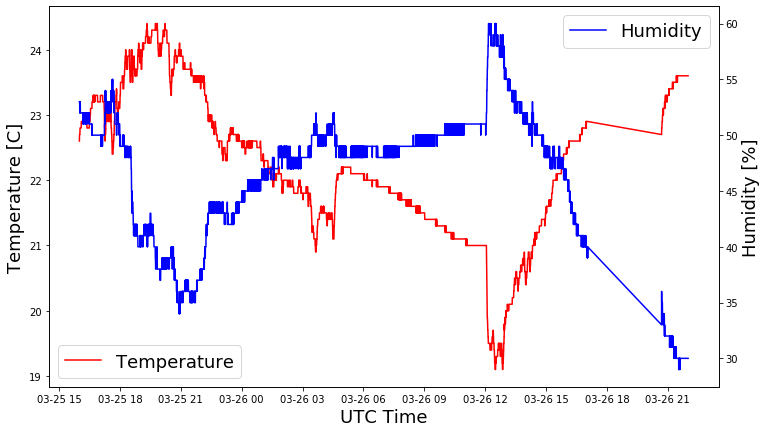

In [129]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df.time, df.temperature, c="r", label="Temperature")
ax.set_xlabel("UTC Time", fontsize=18)
ax.set_ylabel("Temperature [C]", fontsize=18)
ax2 = ax.twinx()
ax2.plot(df.time, df.humidity, c="b", label="Humidity")
ax2.set_ylabel("Humidity [%]", fontsize=18)
ax.legend(fontsize=18, loc=3)
ax2.legend(fontsize=18, loc=1)

# device_id 1

In [130]:
device_id = "1"
min_isotime = "2021-03-28"

In [131]:
df = read_data(device_id, min_isotime)

Querying next page starting at 2021-03-29T01:39:59.643000
Querying next page starting at 2021-03-29T05:02:39.288000
Querying next page starting at 2021-03-29T11:09:01.416000


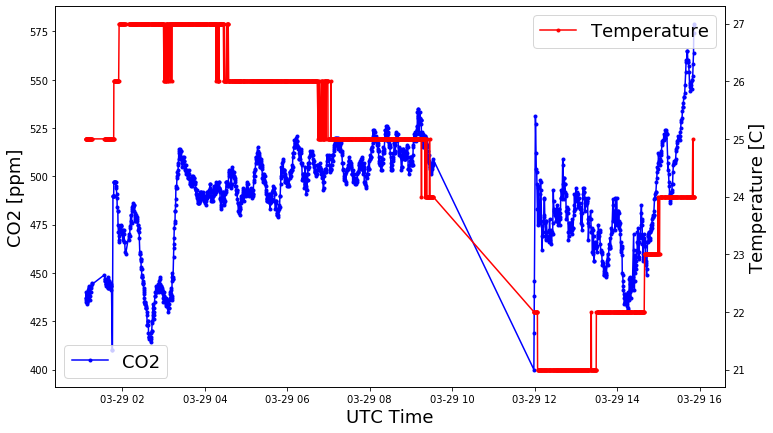

In [138]:
df = update_data(df)

fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(df.time, df.co2, c="b", label="CO2", marker='.')
ax.set_ylabel("CO2 [ppm]", fontsize=18)
ax.set_xlabel("UTC Time", fontsize=18)
ax2 = ax.twinx()
ax2.plot(df.time, df.temperature, c="r", label="Temperature", marker='.')
ax2.set_ylabel("Temperature [C]", fontsize=18)
ax.legend(fontsize=18, loc=3)
ax2.legend(fontsize=18, loc=1)